In [17]:
import pandas as pd
import ast
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt_tab')
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\theal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [30]:
df_test = pd.read_csv('important_data_v3_metrics.csv')

In [28]:
df_test.head()

,conversation_id,user_id,opening_prompt,conversation_history,lm_familiarity,lm_frequency_use,age,gender,employment_status,education,marital_status,english_proficiency,study_locale,religion,ethnicity,location
0,c23,user9,I would like to write a poem about my white cat.,"[{'turn': 0, 'role': 'user', 'content': 'I wou...",Somewhat familiar,Once per month,25-34 years old,Female,Working full-time,Vocational,Never been married,Native speaker,canada,No Affiliation,White,Northern America
1,c158,user18,What is a good and cheap meal?,"[{'turn': 0, 'role': 'user', 'content': 'What ...",Somewhat familiar,More than once a month,18-24 years old,Female,Student,Some University but no degree,Never been married,Advanced,poland,Christian,White,Europe
2,c210,user47,What is the tiniest bird species in Europe?,"[{'turn': 0, 'role': 'user', 'content': 'What ...",Very familiar,Once per month,18-24 years old,Female,"Unemployed, seeking work",Vocational,Never been married,Fluent,spain,No Affiliation,White,Europe
3,c211,user57,Who are the top 10 basketball players of all time,"[{'turn': 0, 'role': 'user', 'content': 'Who a...",Somewhat familiar,Once per month,18-24 years old,Male,Working full-time,Some University but no degree,Never been married,Native speaker,ireland,Christian,White,Europe
4,c251,user1017,Do you like football,"[{'turn': 0, 'role': 'user', 'content': 'Do yo...",Somewhat familiar,Every week,35-44 years old,Male,Working full-time,Graduate / Professional degree,Married,Fluent,belgium,Christian,White,Europe


In [41]:
df_test.iloc[0]['conversation_history']

'[{\'turn\': 0, \'role\': \'user\', \'content\': \'I would like to write a poem about my white cat.\'}, {\'turn\': 0, \'role\': \'model\', \'content\': "Here is a 47-word poem about a white cat:\\n\\nFur as white as fallen snow, \\nWith eyes of clearest blue,\\nOn quiet paws you softly go,\\nNot making much ado.\\nYou curl up small to take a nap,\\nYour tail wrapped round your side,\\nAnd when you wake you stretch and yap,\\nMy sweet cat, winter\'s bride.", \'model_provider\': \'anthropic\', \'model_name\': \'claude-2.1\', \'score\': 69, \'if_chosen\': False, \'within_turn_id\': 0}, {\'turn\': 0, \'role\': \'model\', \'content\': \'Here is a 47-word poem about a white cat:\\n\\nFur as white as fallen snow, \\nWith eyes of clearest blue,\\nPaws that softly come and go,\\nFilled with grace in all you do.\\nCurled up purring by my side,\\nA comforting, gentle friend - \\nMy sweet white cat, in whom I confide,\\nLoyal companion without end.\', \'model_provider\': \'anthropic\', \'model_nam

In [24]:
len(df_test['user_id'].unique())

137

In [31]:


# You gotta run this
#   python -m spacy download en_core_web_sm


def flatten_conversation_history(df):
    """
    Flatten conversation_history in the DataFrame 'df'.
    
    Returns a new turn-level DataFrame with columns:
      [conversation_id, user_id, turn, role, content]
    """
    all_turns = []
    for idx, row in df.iterrows():
        try:
            history_list = ast.literal_eval(row['conversation_history'])
        except Exception as e:
            print(f"Error parsing row {idx} with conversation_id={row.get('conversation_id')}:\n{e}")
            history_list = []
        
        # Build turn-level rows
        for turn_dict in history_list:
            all_turns.append({
                'conversation_id': row['conversation_id'],
                'user_id': row['user_id'],
                'turn': turn_dict.get('turn', None),
                'role': turn_dict.get('role', ''),
                'content': turn_dict.get('content', ''),
                'model': turn_dict.get('model_name', '')
            })
            
    return pd.DataFrame(all_turns)

def get_word_count(text):
    """
    Returns the number of tokens in the string 'text'.
    """
    tokens = nltk.word_tokenize(text)
    return len(tokens)

def get_ttr(text):
    """
    Returns the type-token ratio of the string 'text'.
    """
    tokens = nltk.word_tokenize(text)
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / len(tokens)

def get_syntactic_metrics(text):
    """
    Returns a dict with {'avg_sentence_length', 'max_dep_tree_depth'}.
    """
    doc = nlp(text)
    num_sentences = len(list(doc.sents))
    total_words = len([t for t in doc if not t.is_punct])
    avg_sentence_length = (total_words / num_sentences) if num_sentences > 0 else 0
    
    max_depth = 0
    for token in doc:
        depth = 0
        current = token
        while current.head != current:
            current = current.head
            depth += 1
        max_depth = max(max_depth, depth)

    return {
        'avg_sentence_length': avg_sentence_length,
        'max_dep_tree_depth': max_depth
    }


In [45]:
df = pd.read_csv("important_data_v3_metrics.csv")


print("Initial df shape:", df.shape)
print("Columns in df:", df.columns.tolist())

df_turns = flatten_conversation_history(df)
print("\nFlattened df_turns (first 5 rows):")
print(df_turns.head())

df_turns['word_count'] = df_turns['content'].apply(get_word_count)
df_turns['TTR'] = df_turns['content'].apply(get_ttr)

syntactic_info = df_turns['content'].apply(get_syntactic_metrics)
df_turns['avg_sentence_length'] = syntactic_info.apply(lambda x: x['avg_sentence_length'])
df_turns['parse_tree_depth'] = syntactic_info.apply(lambda x: x['max_dep_tree_depth'])


df_turns_users = df_turns[df_turns['role'] == 'user'].copy()

df_turns_model = df_turns[df_turns['role'] == 'model'].copy()


# d) Aggregate to user level
user_level = (
    df_turns_users
    .groupby("user_id")
    .agg({
        "word_count": "mean",
        "TTR": "mean",
        "avg_sentence_length": "mean",
        "parse_tree_depth": "mean"
    })
    .reset_index()
    .rename(columns={
        "word_count": "mean_word_count",
        "TTR": "mean_TTR",
        "avg_sentence_length": "mean_avg_sentence_length",
        "parse_tree_depth": "mean_parse_tree_depth"
    })
)


Initial df shape: (154, 41)
Columns in df: ['conversation_id', 'user_id', 'opening_prompt', 'conversation_history', 'lm_familiarity', 'lm_frequency_use', 'age', 'gender', 'employment_status', 'education', 'marital_status', 'english_proficiency', 'study_locale', 'religion', 'ethnicity', 'location', 'human_lang', 'llm_lang', 'human_flesch_reading_ease', 'human_flesch_kincaid_grade', 'human_smog_index', 'human_ari', 'human_lexical_diversity', 'human_tb_polarity', 'human_tb_subjectivity', 'human_vader_neg', 'human_vader_neu', 'human_vader_pos', 'human_vader_compound', 'llm_flesch_reading_ease', 'llm_flesch_kincaid_grade', 'llm_smog_index', 'llm_ari', 'llm_lexical_diversity', 'llm_tb_polarity', 'llm_tb_subjectivity', 'llm_vader_neg', 'llm_vader_neu', 'llm_vader_pos', 'llm_vader_compound', 'score']

Flattened df_turns (first 5 rows):
  conversation_id user_id  turn   role  \
0             c23   user9     0   user   
1             c23   user9     0  model   
2             c23   user9     0  m

In [11]:
df.iloc[0]['conversation_history']

'[{\'turn\': 0, \'role\': \'user\', \'content\': \'I would like to write a poem about my white cat.\'}, {\'turn\': 0, \'role\': \'model\', \'content\': "Here is a 47-word poem about a white cat:\\n\\nFur as white as fallen snow, \\nWith eyes of clearest blue,\\nOn quiet paws you softly go,\\nNot making much ado.\\nYou curl up small to take a nap,\\nYour tail wrapped round your side,\\nAnd when you wake you stretch and yap,\\nMy sweet cat, winter\'s bride.", \'model_provider\': \'anthropic\', \'model_name\': \'claude-2.1\', \'score\': 69, \'if_chosen\': False, \'within_turn_id\': 0}, {\'turn\': 0, \'role\': \'model\', \'content\': \'Here is a 47-word poem about a white cat:\\n\\nFur as white as fallen snow, \\nWith eyes of clearest blue,\\nPaws that softly come and go,\\nFilled with grace in all you do.\\nCurled up purring by my side,\\nA comforting, gentle friend - \\nMy sweet white cat, in whom I confide,\\nLoyal companion without end.\', \'model_provider\': \'anthropic\', \'model_nam

In [43]:
df_turns_users.sample(20)

,conversation_id,user_id,turn,role,content,model,word_count,TTR,avg_sentence_length,parse_tree_depth
2699,c7429,user1410,2,user,id like to understand the basics of python pro...,,15,1.000000,17.0,5
2820,c7562,user1444,3,user,Who was the Ancient King who ruled Rhodes?,,9,1.000000,8.0,3
1143,c3319,user613,5,user,what snack should i eat while watching my movie?,,10,1.000000,10.0,3
1468,c4558,user829,2,user,Is 10 hours of sleep too much,,7,1.000000,7.0,3
2198,c6515,user1249,1,user,Hello Claude please tell me the weather forcas...,,9,1.000000,9.0,2
150,c323,user67,3,user,Did I provide a word limit?,,7,1.000000,6.0,2
951,c2764,user512,0,user,What can you tell me about the investigations ...,,12,1.000000,11.0,5
945,c2740,user497,4,user,can you writte a song about feeling sorrow?,,9,1.000000,8.0,3
1261,c3647,user668,5,user,aight ill look into it and make my breath bett...,,15,1.000000,7.0,4
574,c1945,user373,0,user,Please explain to me how the universe came int...,,10,1.000000,10.0,3


In [42]:
# Get average sentennce length and word count across all turns and std dev

df_turns_users['word_count'].mean(), df_turns_users['word_count'].std()


(13.806277056277056, 12.59573624711144)

In [44]:
df_turns_users['avg_sentence_length'].mean(), df_turns_users['avg_sentence_length'].std()

(9.517475778190066, 5.642722976593504)

In [46]:
df_turns_model['word_count'].mean(), df_turns_model['word_count'].std()

(103.39481132075471, 76.1100161927028)

In [47]:
df_turns_model['avg_sentence_length'].mean(), df_turns_model['avg_sentence_length'].std()

(16.256669804159838, 6.680092126924569)

In [35]:
# Get average and std debnumber of turns per conversation_id
avg_turns_per_conversation = df_turns_users.groupby("conversation_id").size().mean()
std_turns_per_conversation = df_turns_users.groupby("conversation_id").size().std()

print(f"Average number of turns per conversation: {avg_turns_per_conversation:.2f} (std={std_turns_per_conversation:.2f})")

Average number of turns per conversation: 6.00 (std=0.00)


In [13]:
user_level

,user_id,mean_word_count,mean_TTR,mean_avg_sentence_length,mean_parse_tree_depth
0,user100,3.833333,1.000000,3.833333,1.333333
1,user1001,6.000000,0.976190,4.833333,2.000000
2,user1008,17.500000,0.940899,14.875000,3.916667
3,user1017,16.083333,0.937964,10.875000,3.500000
4,user106,9.500000,0.953598,7.166667,3.166667
...,...,...,...,...,...
132,user939,9.333333,0.947917,7.833333,2.833333
133,user950,17.083333,0.949234,9.486111,3.416667
134,user956,16.833333,0.956888,11.416667,4.833333
135,user961,22.000000,0.925672,15.055556,4.944444


Merged user data (first 5 rows):
    user_id  mean_word_count  mean_TTR  mean_avg_sentence_length  \
0   user100         3.833333  1.000000                  3.833333   
1  user1001         6.000000  0.976190                  4.833333   
2  user1008        17.500000  0.940899                 14.875000   
3  user1017        16.083333  0.937964                 10.875000   
4   user106         9.500000  0.953598                  7.166667   

   mean_parse_tree_depth              age  gender  employment_status  \
0               1.333333  45-54 years old    Male  Working part-time   
1               2.000000    65+ years old  Female  Working full-time   
2               3.916667  45-54 years old  Female  Working full-time   
3               3.500000  35-44 years old    Male  Working full-time   
4               3.166667  35-44 years old  Female  Working full-time   

                        education        marital_status english_proficiency  \
0                  Some Secondary    Never bee

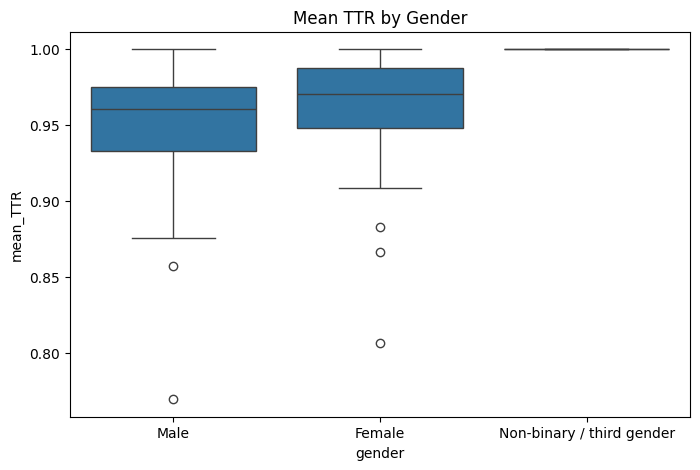

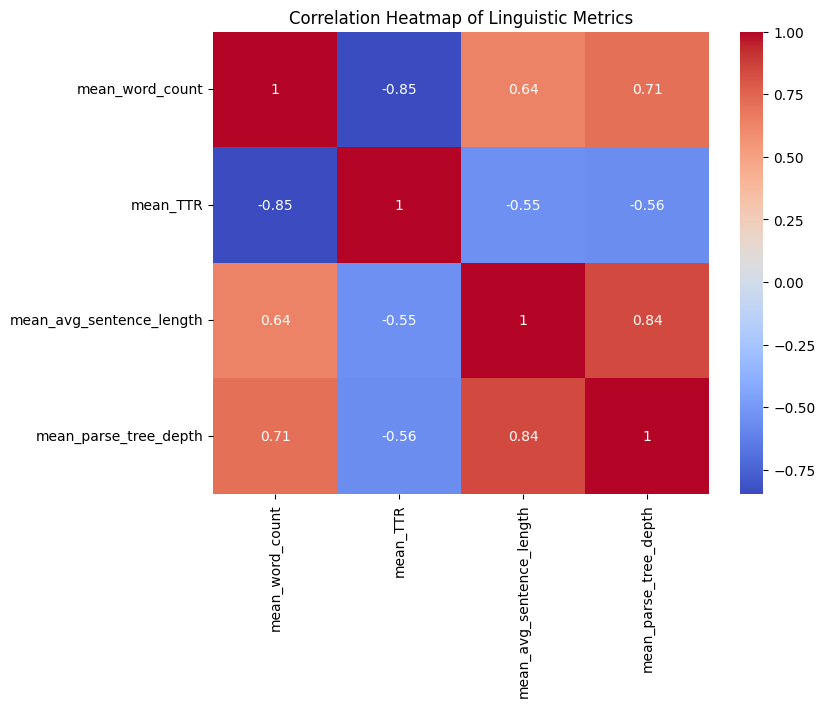

In [14]:
demographics = df[['user_id', 'age', 'gender', 'employment_status', 'education',
                   'marital_status', 'english_proficiency', 'study_locale',
                   'religion', 'ethnicity', 'location']].drop_duplicates()

# Merge the user-level linguistic metrics with the demographic info
user_data = pd.merge(user_level, demographics, on='user_id', how='left')

print("Merged user data (first 5 rows):")
print(user_data.head())


print("\nDescriptive statistics for linguistic metrics:")
print(user_data[['mean_word_count', 'mean_TTR', 'mean_avg_sentence_length', 'mean_parse_tree_depth']].describe())

print("\nGroup means by gender:")
print(user_data.groupby("gender")[['mean_word_count', 'mean_TTR', 'mean_avg_sentence_length', 'mean_parse_tree_depth']].mean())

print("\nGroup means by age:")
print(user_data.groupby("age")[['mean_word_count', 'mean_TTR', 'mean_avg_sentence_length', 'mean_parse_tree_depth']].mean())

print("\nCorrelation matrix for linguistic metrics:")
print(user_data[['mean_word_count', 'mean_TTR', 'mean_avg_sentence_length', 'mean_parse_tree_depth']].corr())


# Example: Boxplot of mean TTR by gender
plt.figure(figsize=(8, 5))
sns.boxplot(x="gender", y="mean_TTR", data=user_data)
plt.title("Mean TTR by Gender")
plt.show()

# Example: Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(user_data[['mean_word_count', 'mean_TTR', 'mean_avg_sentence_length', 'mean_parse_tree_depth']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Linguistic Metrics")
plt.show()


Regression Results for Mean Word Count:
                            OLS Regression Results                            
Dep. Variable:        mean_word_count   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.212
Date:                Sun, 09 Mar 2025   Prob (F-statistic):              0.260
Time:                        00:49:17   Log-Likelihood:                -459.88
No. Observations:                 137   AIC:                             959.8
Df Residuals:                     117   BIC:                             1018.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

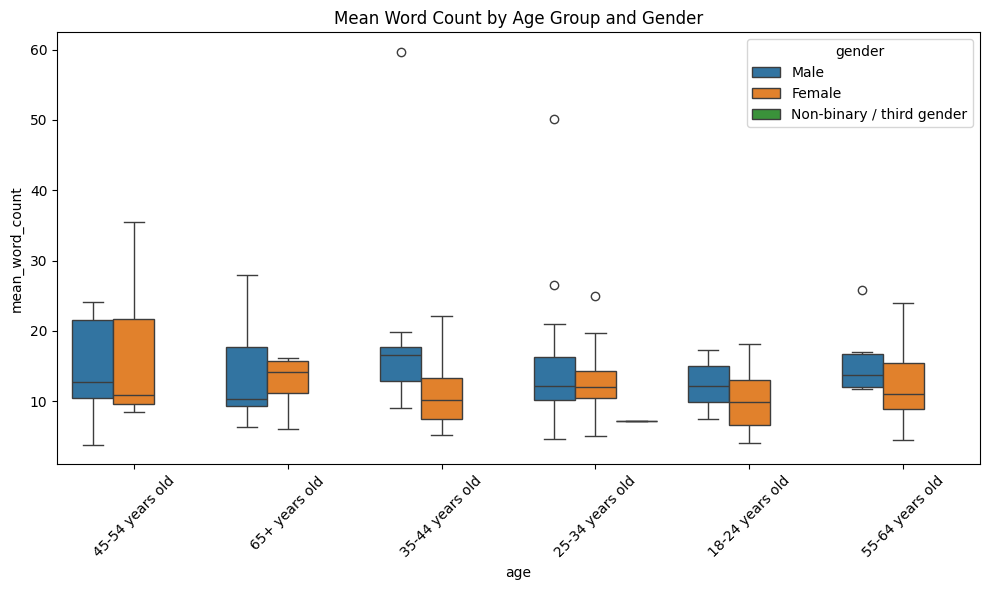

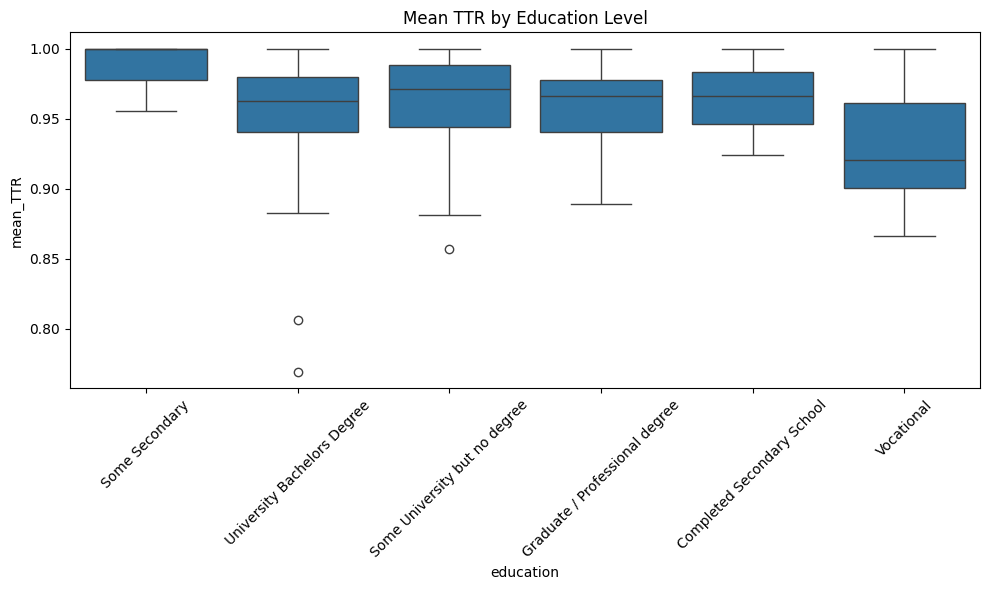

In [15]:
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


model_word = smf.ols("mean_word_count ~ C(age) + C(gender) + C(education) + C(employment_status)", data=user_data).fit()
print("Regression Results for Mean Word Count:")
print(model_word.summary())

model_TTR = smf.ols("mean_TTR ~ C(age) + C(gender) + C(education) + C(employment_status)", data=user_data).fit()
print("\nRegression Results for Mean TTR:")
print(model_TTR.summary())

model_sentence = smf.ols("mean_avg_sentence_length ~ C(age) + C(gender) + C(education) + C(employment_status)", data=user_data).fit()
print("\nRegression Results for Mean Average Sentence Length:")
print(model_sentence.summary())

model_tree = smf.ols("mean_parse_tree_depth ~ C(age) + C(gender) + C(education) + C(employment_status)", data=user_data).fit()
print("\nRegression Results for Mean Parse Tree Depth:")
print(model_tree.summary())


plt.figure(figsize=(10, 6))
sns.boxplot(x="age", y="mean_word_count", hue="gender", data=user_data)
plt.title("Mean Word Count by Age Group and Gender")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Example: Visualizing Mean TTR by Education Level
plt.figure(figsize=(10, 6))
sns.boxplot(x="education", y="mean_TTR", data=user_data)
plt.title("Mean TTR by Education Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np


model_interaction = smf.ols(
    "mean_word_count ~ C(age) * C(education) + C(gender) + C(employment_status)",
    data=user_data
).fit()
print("Regression Results for Mean Word Count with Interaction Terms:")
print(model_interaction.summary())

model_interaction2 = smf.ols(
    "mean_TTR ~ C(gender) * C(marital_status) + C(age) + C(education)",
    data=user_data
).fit()
print("\nRegression Results for Mean TTR with Gender x Marital Status Interaction:")
print(model_interaction2.summary())


Regression Results for Mean Word Count with Interaction Terms:
                            OLS Regression Results                            
Dep. Variable:        mean_word_count   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.149
Date:                Sun, 09 Mar 2025   Prob (F-statistic):              0.291
Time:                        00:49:18   Log-Likelihood:                -448.48
No. Observations:                 137   AIC:                             971.0
Df Residuals:                     100   BIC:                             1079.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
------

c:\Users\theal\.conda\envs\linegym\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
